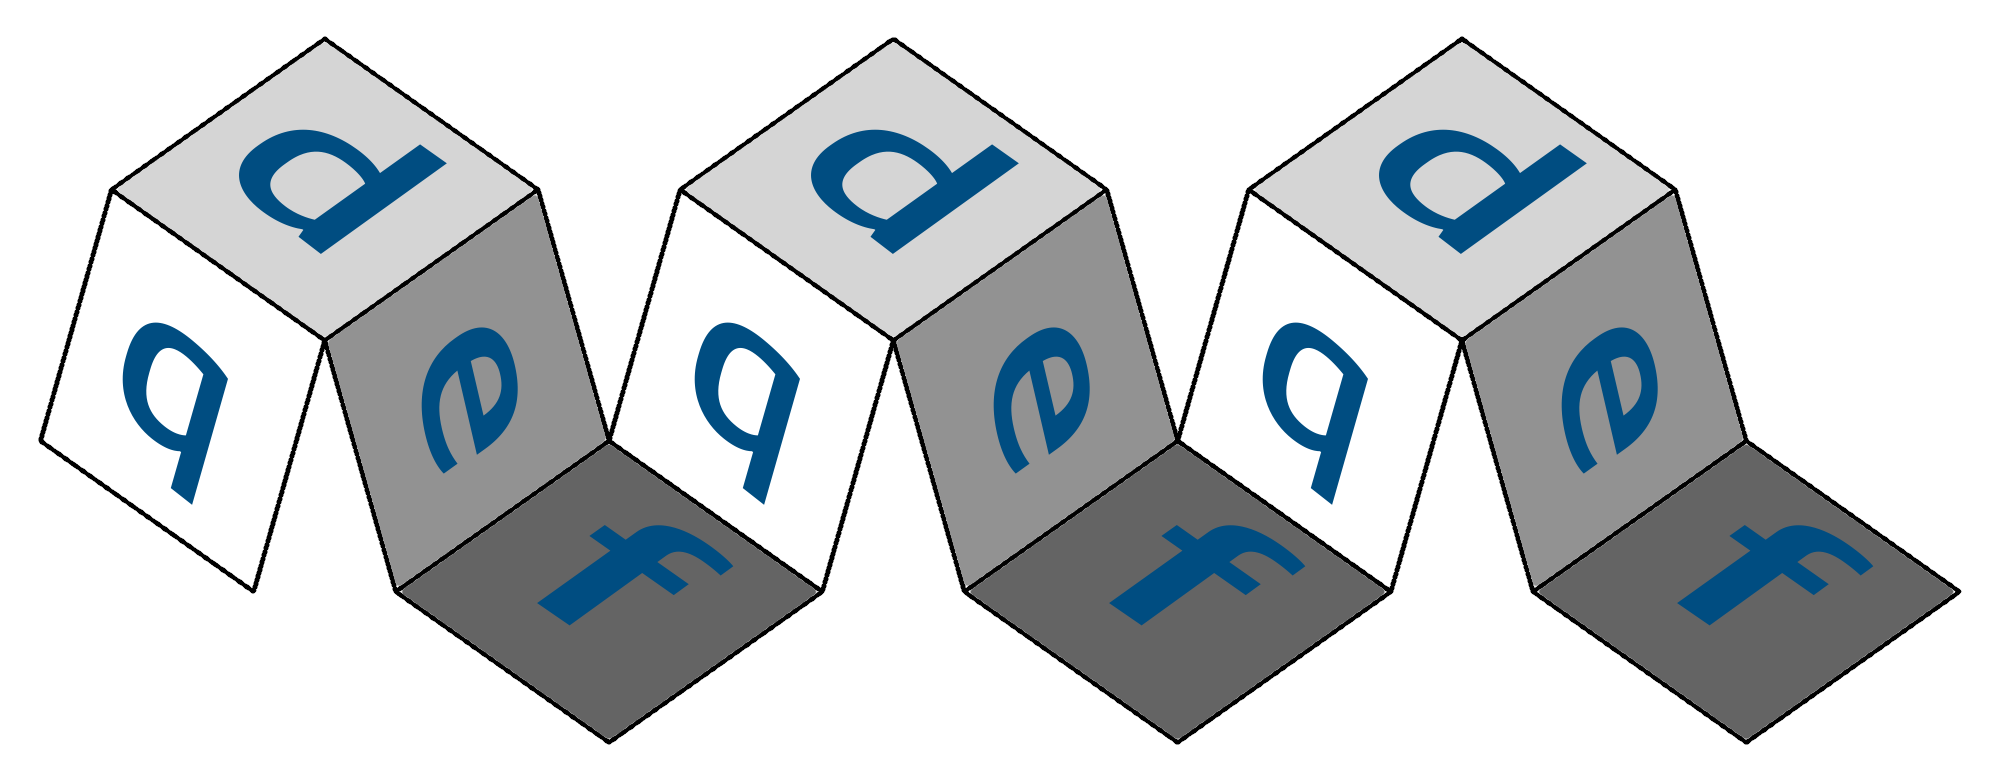

`qdef` is a set of computational tools that integrates group theory calculations for the analysis of multi-electron systems.
In addition to calculating the level structures of single ions using the blah and blah approximation, it also approximates the properties that these single ions would have if embedded in a crystal host in high-symmetry sites.

In this introduction we show the group theory data that it uses for its calculations and the fundamental objects that it uses in order to wrangle with the linear algebra of Hilbert spaces.

In addition `qdef` also includes data on the elements of the periodic table by compiling data from NIST and other sources.

In [11]:
%load_ext autoreload
# provide cell timings
%load_ext autotime
%autoreload 2
import sympy as sp
import numpy as np
from scipy.special import sph_harm as Ynm_num
# from sympy import poly, lambdify
from IPython.display import display, Math
# %config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False
from qdef import *
from itertools import product
from sympy import I
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import HTML, display, Math, Latex
from matplotlib import pyplot as plt
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


# Getting data for the elements

Data for all the elements in the periodic table is included in `qdef`.

In [12]:
# an element can be instantiated
# by using either the element's atomic number,
# symbol, or name.
manganese = Atom(25)
manganese = Atom('Mn')
manganese = Atom('manganese')

In [13]:
# each atom contains a slew of single
# pieces of data
print('\n'.join([manganese.name,
      manganese.symbol,
      str(manganese.atomic_number),
      str(manganese.electronegativity),
      manganese.common_crystal_structure,
      str(manganese.van_der_waals_radius),
      str(manganese.atomic_radius),
      str(manganese.covalent_radius),
      manganese.block + '-block',
      'Period:%d'%manganese.period,
      'Series:%s'%manganese.series,
      'Group:%s'%manganese.group]))
display(Math(manganese.electron_configuration_string))

manganese
Mn
25
1.55
body‐centered cubic
nan
161.0
139.0
d-block
Period:4
Series:TransitionMetal
Group:7


<IPython.core.display.Math object>

In [14]:
# the ionization_energies attribute provides
# the minimum required energy (in eV) to go from one ionization
# stage to the next
print(manganese.ionization_energies)

[7.43402, 15.63999, 33.668, 51.2, 72.4, 95.6, 119.203, 194.5, 221.8, 248.3, 286.0, 314.4, 343.6, 403.0, 435.163, 1134.7, 1224.0, 1317.0, 1437.0, 1539.0, 1644.0, 1788.0, 1879.9, 8140.6, 8571.94]


In [15]:
# The electron configuration is a dictionary with keys equal to
# orbitals and values equal to number of electrons
# this is provided for the neutral species
ec = manganese.electron_configuration
print(ec)
display(Math(''.join(list(map(lambda x: '\\text{%s}^{%d}' % x,list(ec.items()))))))

{'1s': 2, '2s': 2, '2p': 6, '3s': 2, '3p': 6, '3d': 5, '4s': 2}


<IPython.core.display.Math object>

In [16]:
# some attributes correspond to dataframes
# the nist_data attribute provides a dataframe
# with data compiled by NIST
manganese.nist_data

,Element,Charge,Configuration,Term,J,g,Level (eV),Uncertainty (eV),Splitting,Leading percentages,Reference,Lande,J_uncertain,J_has_issues
0,Mn,0,3d5.4s2,a 6S,[5/2],6,0.000000,NaN,,100 ...,L7185,2.00152,False,False
1,Mn,0,3d6.(5D).4s,a 6D,[9/2],10,2.114215,NaN,2.114215,100 ...,,1.559,False,False
2,Mn,0,3d6.(5D).4s,a 6D,[7/2],8,2.142695,NaN,0.02848,100 ...,,1.584,False,False
3,Mn,0,3d6.(5D).4s,a 6D,[5/2],6,2.163713,NaN,0.02102,100 ...,,1.657,False,False
4,Mn,0,3d6.(5D).4s,a 6D,[3/2],4,2.178214,NaN,0.01450,100 ...,,1.866,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,Mn,24,5f,2F*,[5/2],6,8231.394700,NaN,0.00,NaN,,NaN,False,False
22,Mn,24,5f,2F*,[7/2],8,8231.580000,0.1200,0.2,NaN,,NaN,False,False
23,Mn,24,5g,2G,[7/2],8,8231.584100,NaN,0.0,NaN,,NaN,False,False
24,Mn,24,5g,2G,[9/2],10,8231.698000,NaN,0.114,NaN,,NaN,False,False


In [17]:
elements = {i : Atom(i) for i in range(1,119)}

In [18]:
atomic_radii = [[k, atom.atomic_radius] for k, atom in elements.items()]
atomic_radii = np.array(atomic_radii)
covalent_radii = [[k, atom.covalent_radius] for k, atom in elements.items()]
covalent_radii = np.array(covalent_radii)
vdw_radii = [[k, atom.van_der_waals_radius] for k, atom in elements.items()]
vdw_radii = np.array(vdw_radii)

In [21]:
plt.figure(figsize=(7,3))
plt.plot(atomic_radii[:,0],
        atomic_radii[:,1], 'o--', label='atomic radius')
plt.plot(covalent_radii[:,0],
        covalent_radii[:,1], 'o--', label='covalent radius')
plt.plot(vdw_radii[:,0],
        vdw_radii[:,1], 'o--', label='Van der Walls radius')
plt.xlabel('Atomic Number')
plt.ylabel('d / pm')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
# a simple chart of the energy levels of given charged
# species can be called with the level_diagram function
# if the matplotlib backend has been configured thus %matplotlib widget
# then there a simple interactive element to the shown graph
# that on hover shows the energy level together the corresponding
# electron configuration for the state
helium = Atom(2)
helium.level_diagram(1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
# The periodic table class simply loads
# all atoms into a single attribute as a dictionary
# keyed by the atomic numbers
periodicTable = PeriodicTable()

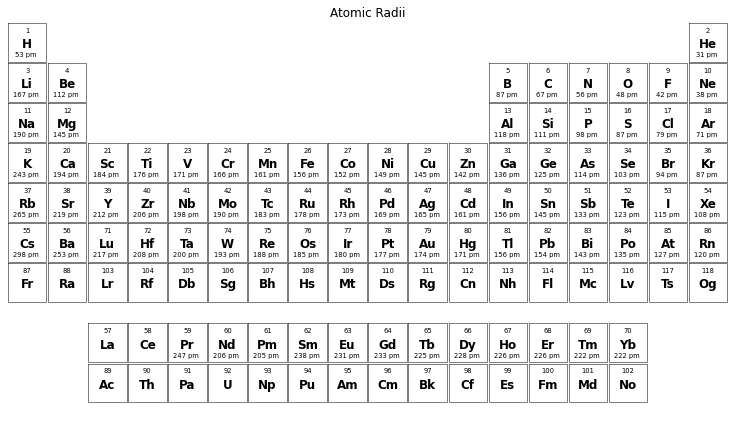

In [31]:
plt.close('ptable')
fig, ax = plt.subplots(num='ptable',figsize=1.1*np.array([9.5,5.5]))
margin = 0.02
annotations = {atom.atomic_number :  '%.0f pm ' % atom.atomic_radius for atom in periodicTable.atoms.values() if not(math.isnan(atom.atomic_radius))}
font_multiplier = 1.7
for atom in periodicTable.atoms.values():
    if atom.group != 'f-block':
        group_loc = int(atom.group)
        row = -atom.period
    else:
        if (57 <= atom.atomic_number <= 70):
            group_loc = atom.atomic_number - 57+3
            row = -9+0.5
        else:
            group_loc = atom.atomic_number - 89+3
            row = -10+0.5
    if atom.atomic_number in annotations.keys():
        plt.text(group_loc+0.5, row-0.8, annotations[atom.atomic_number], ha='center', va='center', fontsize=4*font_multiplier)
    plt.text(group_loc+0.5, row-0.375, atom.symbol,ha='center',va='top',fontsize=7*font_multiplier, weight='bold')
    plt.text(group_loc+0.5, row-margin-0.1, atom.atomic_number,ha='center',va='top',fontsize=4*font_multiplier)
    plt.plot([group_loc+margin, group_loc+1-margin, group_loc+1-margin, group_loc+margin, group_loc+margin],
            [ row-margin, row-margin, row-1+margin, row-1+margin, row-margin],'k-',lw=0.5)
ax.set_xlim(1,19)
ax.set_ylim(-11,-1)
ax.axis('off')
ax.set_aspect('equal')
ax.set_title('Atomic Radii')
plt.tight_layout()
plt.show()

# Defining kets, bras, and brakets

In qdef wavefunctions are handled in the class ```Qet```, which is basically a dictionary with keys equal to quantum numbers or symbols and values which equal the coefficients that accompany them.
When two of these objects are multiplied, it is assumed that the product between them corresponds to a tensor product of them two, this translates in keys being concatenated and coefficients being multiplied (in the normal sense).
The same class can be used to represent kets, bras, or brakets, with the right interpretation and usage left to the user.

For example, the Bell basis may be defined in the following way.

In [11]:
bell_basis = [Qet({(0,0):sp.S(1)/sp.sqrt(2),
            (1,1):sp.S(1)/sp.sqrt(2)}),
       Qet({(0,0):sp.S(1)/sp.sqrt(2),
            (1,1):-sp.S(1)/sp.sqrt(2)}),
       Qet({(1,0):sp.S(1)/sp.sqrt(2),
            (0,1):sp.S(1)/sp.sqrt(2)}),
       Qet({(0,1):sp.S(1)/sp.sqrt(2),
            (1,0):-sp.S(1)/sp.sqrt(2)})
       ]
for qet in bell_basis:
    display(qet.as_ket(True))

sqrt(2)*|00>/2 + sqrt(2)*|11>/2

sqrt(2)*|00>/2 - sqrt(2)*|11>/2

sqrt(2)*|01>/2 + sqrt(2)*|10>/2

sqrt(2)*|01>/2 - sqrt(2)*|10>/2

And if this type of basis is used for the Hilbert space of four qubits, one may then produce the resulting basis: 

In [12]:
bigger_basis = []
for qet in bell_basis:
    new_qets = [q*qet for q in bell_basis]
    bigger_basis.extend(new_qets)
    for n_qet in new_qets:
        display(n_qet.as_ket(True))

TypeError: unsupported operand type(s) for +=: 'Zero' and 'Qet'

We might as well find the transformation of the standard basis that corresponds to the set given above. And confirm that it is a unitary transformation.

In [60]:
basis = list(product((0,1),(0,1),(0,1),(0,1)))

In [61]:
t_matrix = Matrix([ket.vec_in_basis(basis) for ket in bigger_basis]).T

In [62]:
t_matrix

Matrix([
[1/2,  1/2,   0,    0,  1/2,  1/2,    0,    0,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0,   0,    0,    0,    0,    0,    0, 1/2,  1/2,   0,    0,  1/2,  1/2,    0,    0],
[  0,    0,   0,    0,    0,    0,    0,    0, 1/2,  1/2,   0,    0, -1/2, -1/2,    0,    0],
[1/2,  1/2,   0,    0, -1/2, -1/2,    0,    0,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0, 1/2,  1/2,    0,    0,  1/2,  1/2,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0,   0,    0,    0,    0,    0,    0,   0,    0, 1/2,  1/2,    0,    0,  1/2,  1/2],
[  0,    0,   0,    0,    0,    0,    0,    0,   0,    0, 1/2,  1/2,    0,    0, -1/2, -1/2],
[  0,    0, 1/2,  1/2,    0,    0, -1/2, -1/2,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0, 1/2, -1/2,    0,    0,  1/2, -1/2,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0,   0,    0,    0,    0,    0,    0,   0,    0, 1/2, -1/2,    0,    0,  1/2, -1/2],
[  0,    0,   0,    0,    0,    0,    0,    0,   0,

In [64]:
# let's check that this matrix is orthogonal
if t_matrix*t_matrix.T == eye(16):
  print("unitary indeed")
else:
  print("unitary it is not")

unitary indeed


# Applying Functions & Making Substitutions

Given a qet, it is possible to apply an operator to them. These operators take the shape of functions that take quantum numbers and accompaning coefficient, and return dictionaries with new quantum numbers and coefficients.

Say that we want to apply the CNOT gate to each of the kets from the Bell basis.

In [65]:
def CNOT(qnums, coeff):
    if qnums == (0,0):
        return {(0,0): coeff}
    elif qnums == (0,1):
        return {(0,1): coeff}
    elif qnums == (1,0):
        return {(1,1): coeff}
    else:
        return {(1,0): coeff}
# def Sy(qnums, coeff):
#     m0, m1 = qnums
#     if m0 == 1:
#         m0prime = 0
#         coeff = coeff*I
#     else:
#         m0prime = 1
#         coeff = -I*coeff
#     if m1 == 1:
#         m1prime = 0
#         coeff = coeff*I
#     else:
#         m1prime = 1
#         coeff = -I*coeff
#     return {(m0prime,m1prime): coeff}

In [66]:
for ket in bell_basis:
    rhs = latex(ket.apply(CNOT).as_ket(True))
    lhs = latex(ket.as_ket(True))
    dsp = '%s \\rightarrow %s' % (lhs, rhs)
    display(Math(dsp))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Given a qet, one may extract the coefficients that it has in a given basis. This given basis needs to include all the groups of quantum numbers that a ket has. The basis is just a list of lists (or tuples) that correspond to quantum numbers.

The set of coefficients is returned in the same order as the provided basis.

For example, to find the matrix representation of that operator in the standard basis, one may do as follows

In [72]:
basis = list(product((0,1),(0,1)))

In [73]:
sp.Matrix([Qet({ket:1}).apply(CNOT).vec_in_basis(basis) for ket in basis]).T

Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 0, 1],
[0, 0, 1, 0]])

Another example. Let's now assume that the quantum numbers are associated to angular momentum states, and that we wish to find analytical expressions for the effect on $|j,0\rangle$ for a rotation parametrized in terms of Euler angles α, β, γ. This may be done with help of the Wigner_D function included in qdef.

In [74]:
def WignerRot(qnum, coeff):
    j, m = qnum
    return {(j,mp): coeff*Wigner_D(j,mp,m,alpha,beta,gamma) for mp in range(-j,j+1)}

In [75]:
tkets = []
alpha = sp.Symbol("alpha")
beta = sp.Symbol("beta")
gamma = sp.Symbol("gamma")
for j in [0,1,2]:
    tket = Qet({(j,0):1}).apply(WignerRot)
    tkets.append(tket)
    display(tket.as_ket(True))

|00>

sqrt(2)*(-I*sin(gamma) + cos(gamma))*sin(beta/2)*cos(beta/2)*|11> + sqrt(2)*(I*sin(gamma) + cos(gamma))*sin(beta/2)*cos(beta/2)*|1-1> + (-sin(beta/2)**2 + cos(beta/2)**2)*|10>

-2*sqrt(6)*(-I*sin(gamma) + cos(gamma))*(sin(beta/2)**3*cos(beta/2)/2 - sin(beta/2)*cos(beta/2)**3/2)*|21> + 2*sqrt(6)*(I*sin(gamma) + cos(gamma))*(-sin(beta/2)**3*cos(beta/2)/2 + sin(beta/2)*cos(beta/2)**3/2)*|2-1> + sqrt(6)*(-I*sin(2*gamma) + cos(2*gamma))*sin(beta/2)**2*cos(beta/2)**2*|22> + sqrt(6)*(I*sin(2*gamma) + cos(2*gamma))*sin(beta/2)**2*cos(beta/2)**2*|2-2> + (sin(beta/2)**4 - 4*sin(beta/2)**2*cos(beta/2)**2 + cos(beta/2)**4)*|20>

`.subs` is another method that may be called on a qet which goes through the coefficient and making the substitutions given in a dictionary, for example in the qet above, to replace $\beta = \pi$ we do:

In [76]:
tket.subs({beta:pi/2}).as_ket(True)

sqrt(6)*(-I*sin(2*gamma) + cos(2*gamma))*|22>/4 + sqrt(6)*(I*sin(2*gamma) + cos(2*gamma))*|2-2>/4 - |20>/2

# Symmetry-adapted linear combinations

In [44]:
VCF = []
sharm = []
for q in range(1,5):
  wfs = SymmetryAdaptedWFs('O_{h}',q,False,False,True)
  if wfs:
    sharm.append(wfs)
  for qet in wfs:
    l,m = list(qet.dict.keys())[0]
    m = abs(m)
    VCF.append(SubSubSymbol('B',l,m)*qet)

Reloading...


In [54]:
for wf in VCF:
  display(wf.as_ket(True,True))

sqrt(70)*{B}_{{4}{4}}*|40>/24 + 5*{B}_{{4}{4}}*|44>/24 + 5*{B}_{{4}{4}}*|4\bar{4}>/24

In [52]:
wfs = SymmetryAdaptedWFs('C_{i}',q,False,False,True)

Reloading...
